## Calculation of Markers

### Import libraries

In [5]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import re

In [6]:
# --- files (keep your existing data_path / marker_path) ---
# ressortir du dossier 'notebook' pour aller dans 'data'

data_path = "../data/001MoDe_R1.csv"
marker_path = "../data/001MoDe_R1.marker.csv"

In [7]:
# --- 1) parse header from data file (first non-empty line) ---
header = {}
with open(data_path, "r", encoding="utf-8") as f:
    first = ""
    # find first non-empty line
    while True:
        line = f.readline()
        if not line:
            break
        line = line.strip()
        if line:
            first = line
            break

if first:
    # header expected as semicolon-separated key/value fragments
    for part in first.split(";"):
        part = part.strip()
        if not part:
            continue
        # support key=value, key: value, or "key value"
        if "=" in part:
            k, v = part.split("=", 1)
        elif ":" in part:
            k, v = part.split(":", 1)
        else:
            tokens = part.split()
            k = tokens[0]
            v = tokens[1] if len(tokens) > 1 else ""
            k = k.strip()
            v = v.strip()
        k = k.strip()
        v = v.strip()
        # try convert numeric
        try:
            header[k] = float(v)
        except Exception:
            header[k] = v

# print a few header fields like in expected output
for key in ("screenWidth","screenHeight","cornerX","cornerY","centerX","centerY",
            "externalRadius","internalRadius","borderRadius","cursorRadius",
            "indexOfDifficulty","taskRadius","taskTolerance","autoStart",
            "cycleMaxNumber","cycleDuration","software","version","task","isWithLSL",
            "borderColor","backgroundColor","cursorColorRecord","cursorColorWait"):
    if key in header:
        print(f"{key}: {header[key]}")

# --- 2) read markers robustly and collect lines ---
lines = open(marker_path, "r", encoding="utf-8").read().splitlines()

record_start = []
record_end = []
all_markers = []  # (ts, text)

for line in lines:
    parts = line.strip().split(",")
    # need at least 2 columns (date, timestamp)
    if len(parts) < 2:
        continue
    ts_str = parts[1].strip()
    # normalize numeric characters
    ts_str = ts_str.replace(" ", "")
    try:
        ts = int(ts_str)
    except Exception:
        # skip non-timestamp marker lines (or summary lines)
        continue
    txt = line.strip()
    all_markers.append((ts, txt))
    if "DoCycleChange:DoRecord" in line:
        record_start.append(ts)
    elif "DoCycleChange:DoPause" in line:
        record_end.append(ts)

if not record_start or not record_end:
    raise ValueError("Aucun événement 'DoRecord' / 'DoPause' détecté dans le fichier .marker.csv")

# sort timestamps (defensive)
record_start.sort()
record_end.sort()

# --- 3) pair starts to next available end (robust if logs interleave) ---
pairs = []
ei = 0
for s in record_start:
    # advance end index until find end >= s
    while ei < len(record_end) and record_end[ei] < s:
        ei += 1
    if ei < len(record_end):
        pairs.append((s, record_end[ei]))
        ei += 1
    else:
        # unmatched start: break/ignore
        break

if not pairs:
    raise RuntimeError("Aucun couple start/end valide trouvé dans les marqueurs.")

# --- determine normalization origin t0 ---
def _first_data_timestamp(path):
    # scan file quickly for first valid data timestamp (milliseconds)
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            # data rows are like "t,x,y" or the CSV first cell contains "t,x,y"
            # attempt to find first numeric token
            # split on ';' then check first cell for comma form
            cells = ln.split(";")
            cell0 = cells[0].strip()
            if "," in cell0:
                p = [s.strip() for s in cell0.split(",")]
                if p and re.match(r"^-?\d+(\.\d+)?$", p[0].replace(",", ".")):
                    try:
                        return float(p[0])
                    except Exception:
                        continue
            # fallback: if comma-separated row (no semicolon)
            if "," in ln:
                p = [s.strip() for s in ln.split(",")]
                if p and re.match(r"^-?\d+(\.\d+)?$", p[0].replace(",", ".")):
                    try:
                        return float(p[0])
                    except Exception:
                        continue
    return None

t0_data = _first_data_timestamp(data_path)
# prefer data timestamp origin if available, else use first DoRecord timestamp
if t0_data is not None:
    # data timestamps are in ms, keep integer origin
    t0 = int(round(t0_data))
else:
    t0 = pairs[0][0]

# milliseconds intervals and normalized (seconds since chosen origin)
print("\nrecord times (milliseconds since the Unix epoch):")
for s, e in pairs:
    dur_ms = e - s
    print(f"{s} to {e} ({dur_ms/1000.0:.3f} s)")

print("\nrecord times (seconds since the first origin):")
start_record = [ (s - t0)/1000.0 for s, _ in pairs ]
stop_record  = [ (e - t0)/1000.0 for _, e in pairs ]
for s_sec, e_sec in zip(start_record, stop_record):
    print(f"{s_sec:6.3f} to {e_sec:6.3f} ({e_sec - s_sec:6.3f} s)")

# optional: print full marker lines (timestamp : text) like expected listing
print(f"\nMarkers in '{marker_path}':")
for ts, txt in all_markers:
    payload = txt.split(",", 2)[-1].strip()
    print(f"{ts}: {payload}")

screenWidth: 1104.0
screenHeight: 661.0
cornerX: 302.0
cornerY: 80.0
centerX: 552.0
centerY: 330.0
externalRadius: 250.0
internalRadius: 170.0
borderRadius: 1.0
cursorRadius: 16.0
indexOfDifficulty: 28.00696429476858
taskRadius: 209.5
taskTolerance: 47.0
autoStart: 3600.0
cycleMaxNumber: 6.0
cycleDuration: 20.0
software: LSL-mouse
version: 1.2.0rc5
task: CircularTarget
isWithLSL: false

record times (milliseconds since the Unix epoch):
1616776712333 to 1616776732336 (20.003 s)
1616776752340 to 1616776772351 (20.011 s)
1616776792372 to 1616776812386 (20.014 s)
1616776832390 to 1616776852404 (20.014 s)
1616776872419 to 1616776892433 (20.014 s)

record times (seconds since the first origin):
 0.004 to 20.007 (20.003 s)
40.011 to 60.022 (20.011 s)
80.043 to 100.057 (20.014 s)
120.061 to 140.075 (20.014 s)
160.090 to 180.104 (20.014 s)

Markers in '../data/001MoDe_R1.marker.csv':
1616776712325: KeyTyped=32 DoCycleChange
1616776712331: DoCycleChange:DoStartCycleTimedSequence
1616776712333: D

In [8]:
# Define variables from header for later use
screenWidth  = header.get("screenWidth") 
screenHeight = header.get("screenHeight")
centerX      = header.get("centerX")
centerY      = header.get("centerY")
cornerX      = header.get("cornerX")
cornerY      = header.get("cornerY")
externalRadius = header.get("externalRadius")
internalRadius = header.get("internalRadius")
borderRadius   = header.get("borderRadius")
cursorRadius   = header.get("cursorRadius")
indexOfDifficulty = header.get("indexOfDifficulty")
taskRadius      = header.get("taskRadius")
tasktolerance   = header.get("taskTolerance")
autoStart      = header.get("autoStart")
cycleMaxNumber = header.get("cycleMaxNumber")
cycleDuration  = header.get("cycleDuration")

In [9]:
# --- Lecture du fichier (avec 4 colonnes : t, x, y, in_target) ---
timestamps = []
mouseX = []
mouseY = []
in_target = []

In [10]:
with open(data_path, "r") as f:
    reader = csv.reader(f, delimiter=';')  # ou ',' selon ton fichier
    rows = list(reader)

for r in rows:
    if len(r) >= 1 and ',' in r[0]:
        parts = r[0].split(',')
        if len(parts) >= 4:  # timestamp, X, Y, in_target
            try:
                t = float(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                flag = int(float(parts[3]))  # 1 ou 0
                timestamps.append(t)
                mouseX.append(x)
                mouseY.append(y)
                in_target.append(flag)
            except ValueError:
                continue


In [11]:
# --- Conversion en arrays numpy ---
timestamps = np.array(timestamps)
mouseX = np.array(mouseX)
mouseY = np.array(mouseY)
in_target = np.array(in_target)

In [12]:
# --- Conversion du temps en secondes ---
time = (timestamps - timestamps[0]) / 1000.0  # passage en secondes

In [13]:
# Normalisation du temps
t0 = min(record_start + record_end)
start_record = [(t - t0) / 1000.0 for t in record_start]
stop_record  = [(t - t0) / 1000.0 for t in record_end]

In [14]:
# --- 2. Lecture du fichier principal (positions souris) ---
timestamps, mouseX, mouseY = [], [], []

with open(data_path, "r") as f:
    reader = csv.reader(f, delimiter=';')
    for r in reader:
        if len(r) >= 1 and ',' in r[0]:
            parts = r[0].split(',')
            if len(parts) >= 3:
                try:
                    t = float(parts[0])
                    x = float(parts[1])
                    y = float(parts[2])
                    timestamps.append(t)
                    mouseX.append(x)
                    mouseY.append(y)
                except ValueError:
                    pass

In [15]:
# Convertir en arrays numpy
timestamps = np.array(timestamps)
mouseX = np.array(mouseX)
mouseY = np.array(mouseY)

In [16]:
# --- 3. Normalisation du temps principal ---
timestamps = (timestamps - timestamps[0]) / 1000.0  # passage en secondes

In [17]:
# --- Lecture du fichier ---
with open(marker_path, "r") as f:
    lines = f.readlines()

record_start = []
record_end = []
timestamp_all = []

# --- Extraction des timestamps ---
for line in lines:
    parts = line.strip().split(",")
    if len(parts) < 3:
        continue 
    try:
        ts = int(parts[1])     
        timestamp_all.append(ts)   
    except ValueError:
        continue 

    if "DoCycleChange:DoRecord" in line:
        record_start.append(ts)
    elif "DoCycleChange:DoPause" in line:
        record_end.append(ts)

# --- Vérifications ---
if len(record_start) == 0:
    raise ValueError("Aucun événement 'DoRecord' détecté dans le fichier.")
if len(record_end) == 0:
    raise ValueError("Aucun événement 'DoPause' détecté dans le fichier.")
if len(record_start) != len(record_end):
    print("⚠️ Attention : nombre de débuts et de fins différents. Vérifie le log.")

# --- Normalisation du temps ---
t0 = min(record_start + record_end)
start_record = [(t - t0) / 1000.0 for t in record_start]
stop_record = [(t - t0) / 1000.0 for t in record_end]

# --- Calcul des durées pour chaque tâche ---
task_durations = []
for start, end in zip(start_record, stop_record):
    duration = end - start
    task_durations.append(duration)

# --- Affichage ---
print("Start times (s):", start_record)
print("End times (s):", stop_record)
print("Durations (s):", task_durations)

# Optionnel : résumé propre
print("\nRésumé des tâches :")
for i, (start, end, dur) in enumerate(zip(start_record, stop_record, task_durations), start=1):
    print(f"Tâche {i}: début = {start:.2f}s, fin = {end:.2f}s, durée = {dur:.2f}s")

Start times (s): [0.0, 40.007, 80.039, 120.057, 160.086]
End times (s): [20.003, 60.018, 100.053, 140.071, 180.1]
Durations (s): [20.003, 20.011000000000003, 20.013999999999996, 20.013999999999996, 20.01399999999998]

Résumé des tâches :
Tâche 1: début = 0.00s, fin = 20.00s, durée = 20.00s
Tâche 2: début = 40.01s, fin = 60.02s, durée = 20.01s
Tâche 3: début = 80.04s, fin = 100.05s, durée = 20.01s
Tâche 4: début = 120.06s, fin = 140.07s, durée = 20.01s
Tâche 5: début = 160.09s, fin = 180.10s, durée = 20.01s


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


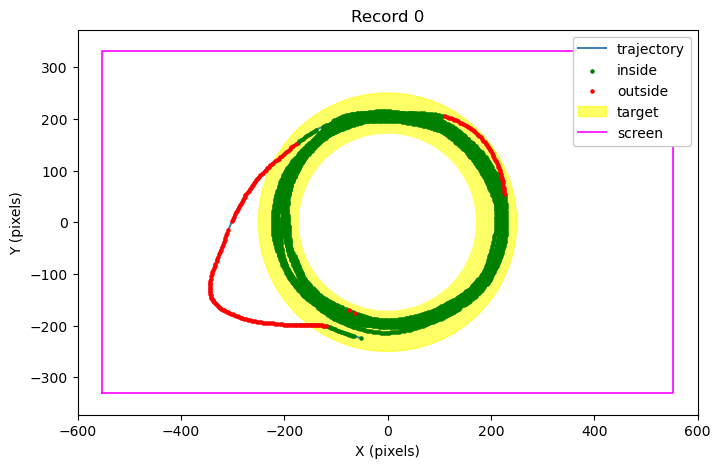

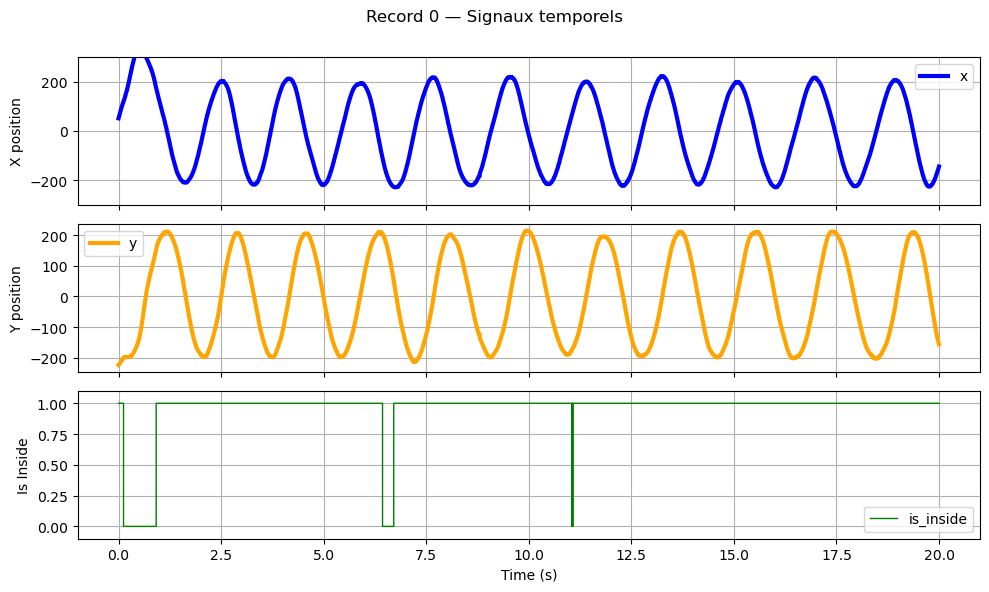

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


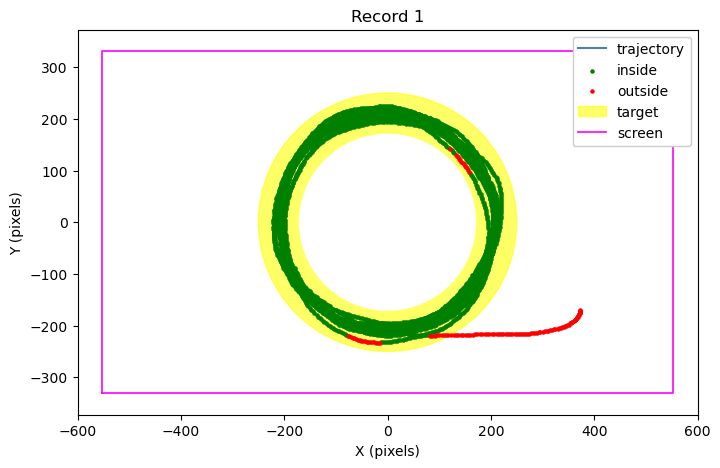

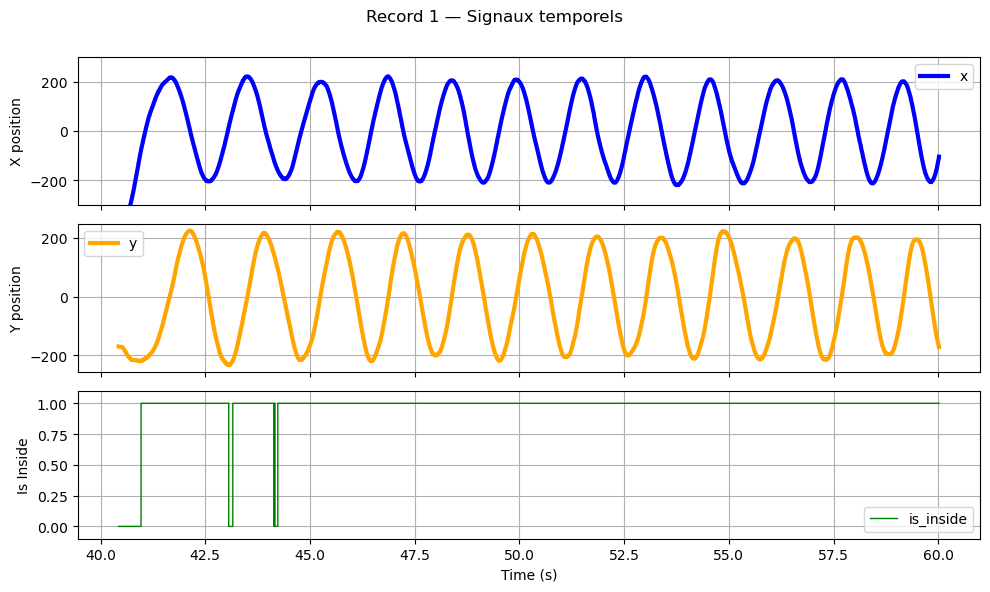

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


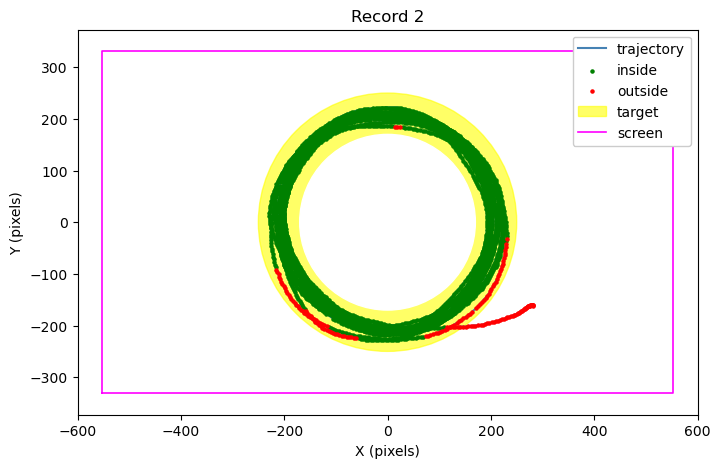

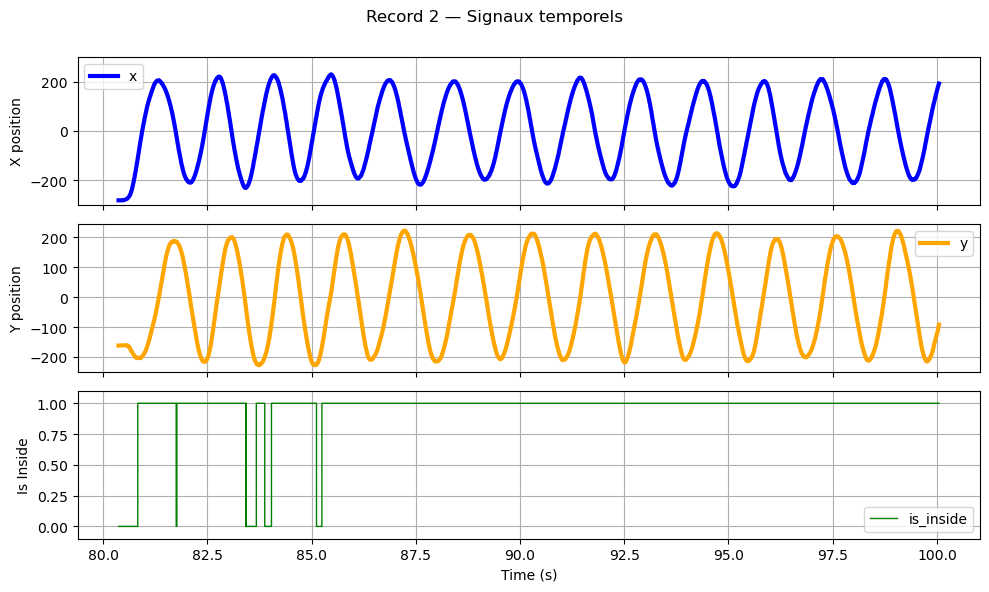

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


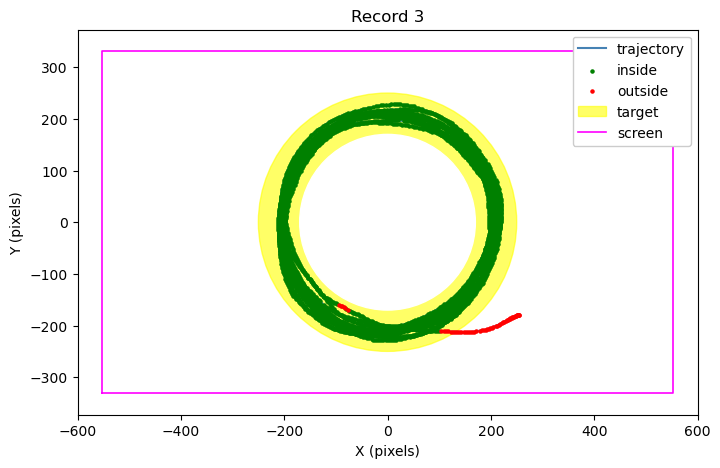

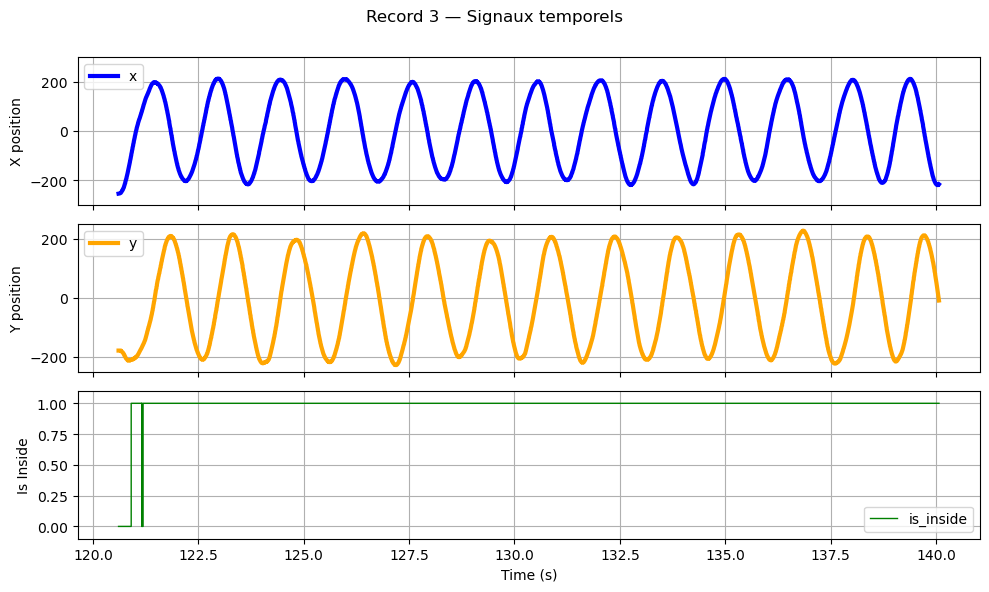

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


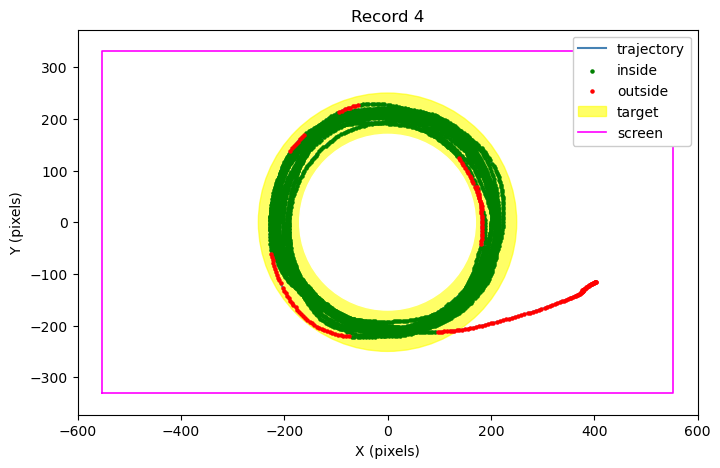

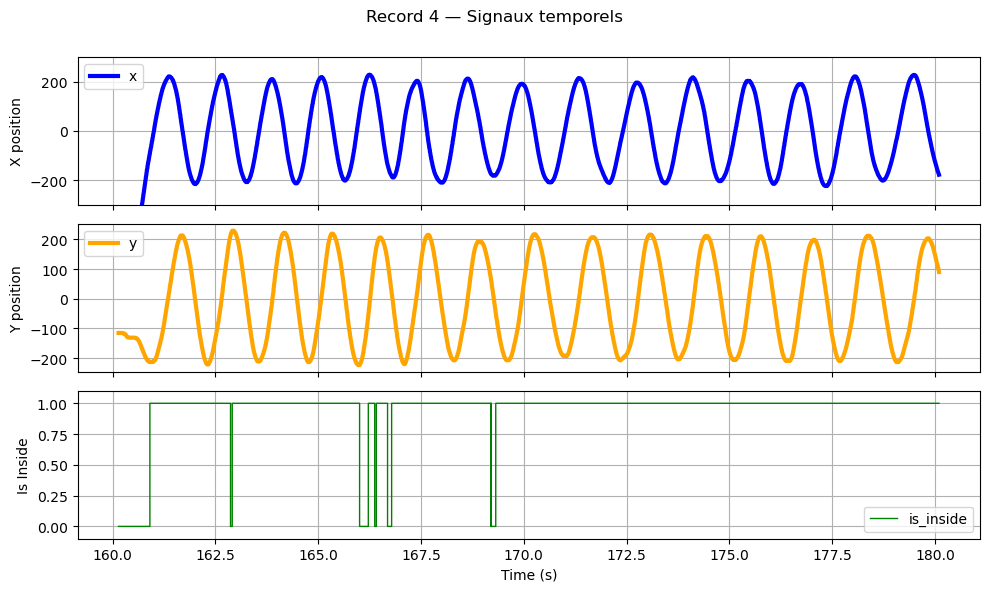

In [18]:
# --- 1. Lecture du fichier (avec in_target inclus) ---
timestamps, mouseX, mouseY, in_target = [], [], [], []

with open(data_path, "r") as f:
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)

for r in rows:
    if len(r) >= 1 and ',' in r[0]:
        parts = r[0].split(',')
        if len(parts) >= 4:
            try:
                t = float(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                flag = int(float(parts[3]))  # 1 = inside, 0 = outside
                timestamps.append(t)
                mouseX.append(x)
                mouseY.append(y)
                in_target.append(flag)
            except ValueError:
                continue

# --- Conversion en arrays numpy ---
timestamps = np.array(timestamps)
mouseX = np.array(mouseX)
mouseY = np.array(mouseY)
in_target = np.array(in_target)

# --- Temps en secondes ---
timestamps = (timestamps - timestamps[0]) / 1000.0

# --- Normalisation des longueurs pour éviter l'erreur ---
m = min(len(timestamps), len(mouseX), len(mouseY), len(in_target))
timestamps = timestamps[:m]
mouseX = mouseX[:m]
mouseY = mouseY[:m]
in_target = in_target[:m]

# --- 2. Boucle principale sur les records ---
records_data = []

for i, (start, end) in enumerate(zip(start_record, stop_record), start=0):
    mask = (timestamps >= start) & (timestamps <= end)
    x_task = mouseX[mask] - centerX
    y_task = -(mouseY[mask] - centerY)
    t_task = timestamps[mask]
    in_task = in_target[mask]

    records_data.append({
        "record": i,
        "time": t_task,
        "x": x_task,
        "y": y_task,
        "in_target": in_task
    })

    # ======================================================
    # 1️⃣ GRAPHIQUE SPATIAL (trajectoire + cible)
    # ======================================================
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(x_task, y_task, '-', color='steelblue', label='trajectory', zorder=2)
    ax1.scatter(x_task[in_task == 1], y_task[in_task == 1],
                color='green', s=5, label='inside', zorder=3)
    ax1.scatter(x_task[in_task == 0], y_task[in_task == 0],
                color='red', s=5, label='outside', zorder=3)

    # Cible (anneau)
    circle_outer = plt.Circle((0, 0), externalRadius, color='yellow', alpha=0.6, zorder=1, label='target')
    circle_inner = plt.Circle((0, 0), internalRadius, color='white', zorder=2)
    ax1.add_patch(circle_outer)
    ax1.add_patch(circle_inner)

    # Bordure écran
    ax1.plot([-screenWidth/2, screenWidth/2, screenWidth/2, -screenWidth/2, -screenWidth/2],
             [-screenHeight/2, -screenHeight/2, screenHeight/2, screenHeight/2, -screenHeight/2],
             color='magenta', lw=1.2, label='screen', zorder=0)

    ax1.set_title(f"Record {i}")
    ax1.set_xlabel("X (pixels)")
    ax1.set_ylabel("Y (pixels)")
    ax1.axis("equal")
    ax1.set_xlim(-600, 600)
    ax1.set_ylim(-400, 400)
    ax1.legend(loc='upper right', framealpha=1, facecolor='white')
    ax1.grid(False)
    plt.show()

    # ======================================================
    # 2️⃣ GRAPHIQUES TEMPORELS (X, Y, Inside)
    # ======================================================
    fig2, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    fig2.suptitle(f"Record {i} — Signaux temporels")

    # X
    axes[0].plot(t_task, -x_task, color='blue', label='x', lw=3)
    axes[0].set_ylabel("X position")
    axes[0].set_ylim(-300, 300)
    axes[0].legend()
    axes[0].grid(True)

    # Y
    axes[1].plot(t_task, y_task, color='orange', label='y', lw=3)
    axes[1].set_ylabel("Y position")
    axes[0].set_ylim(-300, 300)
    axes[1].legend()
    axes[1].grid(True)

    # Inside (issu du fichier)
    axes[2].step(t_task, in_task, where='post', color='green', label='is_inside', lw=1)
    axes[2].set_ylabel("Is Inside")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylim(-0.1, 1.1)
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


In [19]:
# --- Tes données existantes ---
# time, in_target sont déjà définis
start_record = [0.0, 40.007, 80.039, 120.057, 160.086]
stop_record  = [20.003, 60.018, 100.053, 140.071, 180.1]

# --- Création des 5 graphes ---
plt.figure(figsize=(18, 5))

# --- Tracé des positions centrées (points pour lisibilité fine) ---
plt.plot(time, X - np.mean(X), '.', ms=3, color='tab:blue', label='x position')
plt.plot(time, Y - np.mean(Y), '.', ms=3, color='tab:orange', label='y position')

# --- Marqueurs de début et fin d’enregistrement ---
for s in start_record:
    plt.axvline(s, color='black', linestyle='--', linewidth=1.2, label='record start' if s == start_record[0] else "")
for e in stop_record:
    plt.axvline(e, color='red', linestyle='--', linewidth=1.2, label='record end' if e == stop_record[0] else "")

# --- Ajustements visuels ---
plt.xlim(min(time[0], start_record[0]) - 1, max(time[-1], stop_record[-1]) + 1)
plt.ylim(np.min([X - np.mean(X), Y - np.mean(Y)]) - 50, np.max([X - np.mean(X), Y - np.mean(Y)]) + 50)

plt.xlabel("Time")
plt.ylabel("Valeur")
plt.title("Raw time series data")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

NameError: name 'X' is not defined

<Figure size 1800x500 with 0 Axes>